In [1]:
#normal tools:                                                                                                                                                                 
from scipy import sparse
import numpy as np
import copy
import sys
sys.path.append("..")
import utils

#learning libraries:                                                                                                                                                           
import implicit
import lightfm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
year=2010
interaction_matrix = sparse.load_npz('../data/interaction_matrix_pchembl.npz')
interaction_matrix = np.array(interaction_matrix.todense())

interaction_dates = sparse.load_npz('../data/interaction_dates_pchembl.npz')
interaction_dates = np.array(interaction_dates.todense())

split = np.array(interaction_dates<=year, dtype=int)
train = interaction_matrix*split
test = interaction_matrix - train
test.shape

(337951, 243)

In [3]:
#remove rows with no labels from the train matrix:
rowmask = np.sum(train, axis=1).nonzero()[0]

train = train[rowmask]
test = test[rowmask]
test.shape

(157161, 243)

In [ ]:
##load data for bootstrap split:                                                                                                                                         
interaction_matrix = utils.load_subset()
btrain, btest = utils.train_test_split(interaction_matrix, 0.05)

In [4]:
def find_opt_pars(filename):
    f = open('../hyperparmeter_optimization/'+filename, 'r')
    record=False
    for line in f:
        if 'Paramaters:' in line:
            return [float(i) for i in line.strip('\n').replace('[', '').replace(']', '').replace(',', '').split()[1:]]


In [5]:
def train_implicit_bpr(pars, inp):
    model = implicit.bpr.BayesianPersonalizedRanking(factors=int(pars[0]),
                                                 learning_rate=pars[1],
                                                 regularization=pars[2],
                                                 iterations=int(pars[3]),
                                                 use_gpu=False)

    model.fit(sparse.csr_matrix(inp), show_progress=False)
    return np.dot(model.item_factors, model.user_factors.T)

def train_lc(inp):
    L1 = 1- utils.makeCorrelations(inp)
    return utils.makeProbabilities(inp, L1)

In [30]:
pars = find_opt_pars('hpo_implicit_bpr.dat')
im_pm = train_implicit_bpr(pars, train.T)


[[   432 126717 128706 ...  74031 133424  58904]
 [ 93326  54439  20678 ... 134438  31960  99301]
 [  2236  96712 125217 ...  71408 143692  93386]
 ...
 [ 67979  36491  37394 ... 105942  12372 128765]
 [ 47246  47661  89998 ... 149053 124920 127781]
 [  5963  48701  62081 ...  99352  97949  63450]]


In [34]:
f = utils.evaluate_predictions(im_pm.T, train, sparse.csr_matrix(test))
print(f)

0.5749799518845229


In [6]:
pars = find_opt_pars('hpo_implicit_bpr.dat')
im_pm = train_implicit_bpr(pars, train)
f = utils.evaluate_predictions(im_pm, train, sparse.csr_matrix(test))
print(f)
#r = f[test.astype(bool)]
#print((r<20).sum() / len(r))



for _ in range(20):
    new_idx = np.arange(0,train.shape[0])
    np.random.shuffle(new_idx)
    im_pm += train_implicit_bpr(pars, train[new_idx])[new_idx.argsort()]

    
    f = utils.evaluate_predictions(im_pm, train, sparse.csr_matrix(test))
    print(f)
    #r = f[test.astype(bool)]
    #print((r<20).sum() / len(r))

0.5749799518845229
0.6038492381716118
0.6166800320769847
0.6174819566960705
0.6190858059342422
0.6190858059342422
0.6230954290296712
0.623897353648757
0.6230954290296712
0.6267040898155574
0.6263031275060145
0.6251002405773858
0.6263031275060145
0.628307939053729
0.6299117882919005
0.6303127506014434
0.6295108259823576
0.6287089013632718
0.6307137129109863
0.628307939053729
0.627906976744186


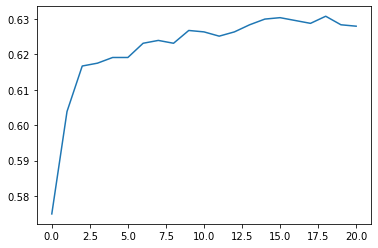

In [12]:
b = """0.5749799518845229
0.6038492381716118
0.6166800320769847
0.6174819566960705
0.6190858059342422
0.6190858059342422
0.6230954290296712
0.623897353648757
0.6230954290296712
0.6267040898155574
0.6263031275060145
0.6251002405773858
0.6263031275060145
0.628307939053729
0.6299117882919005
0.6303127506014434
0.6295108259823576
0.6287089013632718
0.6307137129109863
0.628307939053729
0.627906976744186
"""
plt.plot([float(i) for i in b.split()])
#plt.ylim(0.55,0.65)

In [ ]:
plt.plot(results)


In [26]:
import lightfm
model = lightfm.LightFM(no_components = 128,
                           loss='warp', 
                           max_sampled=10,
                           learning_rate=0.06800399888746232)
model.fit(sparse.csr_matrix(train).T, epochs=4)
#lightfm 'user id' (chemical id)                                                                                                                                               
cid = np.arange(train.T.shape[0])
#lightfm 'item id' (target id)                                                                                                                                                 
tid = np.arange(train.T.shape[1])
#make interaction predictions:                                                                                                                                         
lfm = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
lfm = np.reshape(lfm, (len(cid), len(tid)))


f = utils.evaluate_predictions(lfm, train, sparse.csr_matrix(test), outtype='full')
#r = f[test.astype(bool)]
#print((r<20).sum() / len(r))

In [27]:
f = utils.evaluate_predictions(lfm, train, sparse.csr_matrix(test), outtype='full')

In [29]:
f

array([[   432, 126717, 128706, ...,  74031, 133424,  58904],
       [ 93326,  54439,  20678, ..., 134438,  31960,  99301],
       [  2236,  96712, 125217, ...,  71408, 143692,  93386],
       ...,
       [ 67979,  36491,  37394, ..., 105942,  12372, 128765],
       [ 47246,  47661,  89998, ..., 149053, 124920, 127781],
       [  5963,  48701,  62081, ...,  99352,  97949,  63450]])

In [ ]:
model = lightfm.LightFM(no_components = 128,
                           loss='warp', 
                           max_sampled=10,
                           learning_rate=0.06800399888746232)
model.fit(sparse.csr_matrix(train), epochs=4)

In [ ]:
r = f[test.astype(bool)]


In [ ]:
(r<20).sum() / len(r)

In [37]:
import lightfm
model = lightfm.LightFM(no_components = 128,
                           loss='warp', 
                           max_sampled=10,
                           learning_rate=0.06800399888746232)
model.fit(sparse.csr_matrix(train).T, epochs=4)
#lightfm 'user id' (chemical id)                                                                                                                                               
cid = np.arange(train.T.shape[0])
#lightfm 'item id' (target id)                                                                                                                                                 
tid = np.arange(train.T.shape[1])
#make interaction predictions:                                                                                                                                         
lfm = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
lfm = np.reshape(lfm, (len(cid), len(tid)))


f = utils.evaluate_predictions(lfm.T, train, sparse.csr_matrix(test))
print(f)
for _ in range(10):
    model = lightfm.LightFM(no_components = 128,
                           loss='warp', 
                           max_sampled=10,
                           learning_rate=0.06800399888746232)
    model.fit(sparse.csr_matrix(train).T, epochs=4)

    #make interaction predictions:                                                                                                                                         
    pre = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
    lfm += np.reshape(pre, (len(cid), len(tid)))
    f = utils.evaluate_predictions(lfm.T, train, sparse.csr_matrix(test))
    #r = f[test.astype(bool)]
    #print((r<20).sum() / len(r))
    print(f)

0.2866880513231756
0.29149959903769046
0.2995188452285485


KeyboardInterrupt: 

In [ ]:
lc_pm = train_lc(train)
#pars = find_opt_pars('hpo_implicit_bpr.dat')
#im_pm = train_implicit_bpr(pars, btrain)

In [35]:
#order from highest to lowest:    
preds_ma = np.ma.masked_array(im_pm.T, mask=train.astype(bool))
order = (-preds_ma).argsort(axis=0)
#get ranks of each ligand.                                                                                                                                                 
ranks = order.argsort(axis=0)
print(ranks[test.astype(bool)][:200])

[  1628     59  20834  13213 132709   1732    250   1158 101021   4945
 137432      6    181  13530   5643    220  84578   1108  10655   8166
   8050     97    621   2114  87469    828    433  96999    201    628
  11602   1582   1688   1401  39182  93213    572   1769   1495   2204
     45    317    803      5    531   1234    955     42    179    153
    407  58663  53679    144    174 131899     16      9  12197  36699
  41257  57273  50177  62007   4565     14    243  38778   3616  52868
   3118  61383   3750     88 125125   7232   6983  13017   3871   2689
  21023  12998   7251   1674   1466   1743   1657    629    273  97306
  82597   2634    813    208    882     29   9503     21  12469 121218
 139677  29151    507    743      3    145   1144   2423    166    857
   1255   1435    472  15371  18299  41299  18075    640  60830  84997
  42437   9504  23773   2543  13231    932 153705 154371 155842 155546
     22  36203   2636  54390   3711  63009   3958  37989   2432  30678
   213

In [36]:
(ranks[test.astype(bool)]<30).sum()/2494

0.0408981555733761

In [39]:
#order from highest to lowest:    
preds_ma = np.ma.masked_array(lfm, mask=train.astype(bool)).T
order = (-preds_ma).argsort(axis=0)
#get ranks of each ligand.                                                                                                                                                 
ranks = order.argsort(axis=0)
print(ranks[test.astype(bool)][:200])
print((ranks[test.astype(bool)]<30).sum()/2494)

[  1282    522   1943   1456  50546   1715   1231   4958  76660   9659
  68771   1111    134  20419   4814   2519  64795   1103  14052 149749
  13359   1105   1584   1323  73028    635    756   6355   2612   4186
  19479   3507   3950   4643  15051 105339    499   2921   2190   3009
     60   3400   4201      0   4249   4491   2934   2050   2243   2224
   2262  75155  67127    476     22  78817    478    168 116110  36687
  81461  25330  55073  19460  34317   1676   1419  13237   6403  63400
 101789 134789 101627   2086  50156   2218  11892  46584   3280   4363
  12651  58500   2824   2165   2185   2512   2385   2050   1086 118031
  10349   1884   1730   1232   1748   1037   5728   1064   4663  57351
 128438 101725   2407   3587    531   4143   2832   3243  10412   1816
   1060   1088   1341   9448  38884  72771  35162   1269  55563  61776
  69560  26018  32620   8621 101477    148 156283 155885 155520 155925
   1584  24718  31280 107834  94531  22865  20373   2274  34505  21272
  9961

In [24]:
lfc = train_lc(train)

In [25]:
#order from highest to lowest:    
preds_ma = np.ma.masked_array(lfc, mask=train.astype(bool))
order = (-preds_ma).argsort(axis=0)
#get ranks of each ligand.                                                                                                                                                 
ranks = order.argsort(axis=0)
print(ranks[test.astype(bool)][:200])
print((ranks[test.astype(bool)]<30).sum()/2494)

[   337      0    378    492      0   1644    231   1611  40571  10019
   2669     96      7    330   4196      0  30474   1608   3125  76266
  54619     11    224   2166  38067   1037    426 116427    242   1048
    954    840   1510   1275   9456  54106    354   1235    991   1776
    122    301   1060    107    277   1136    932     70    852    225
    417   3334   1197    229    205 123557    117    101  33194  19835
  19650  19629  19684  19681   3601     47    109  19626   5199  19869
   4616  19767   5000    425 101798   7761   7776  16106  10619   4064
  16821  15648  10967   1942   1289   1906   1287    514    211  31306
  12003    262    285     36    145     14    735     35    603  14796
  34840  17702     16      3      0    522   2421   2265    149    428
   1314   1574    865  13432  20601  22647  19679    629  23578  31108
  35489  17162  15190     58 117593    591   9309   9493   8689  11919
     37  19799   3742  19801   3744  19806   3750  19807   3752  19777
   374

In [ ]:
#order from highest to lowest:    
#preds_ma = np.ma.masked_array(im_pm, mask=train.astype(bool))
order = (-im_pm).argsort()
#get ranks of each ligand.                                                                                                                                                 
ranks = order.argsort()
print(ranks[test.astype(bool)][:20])

In [ ]:
#order from highest to lowest:                                                                                                                                             
order = (-im_pm).argsort(axis=0)
#get ranks of each ligand.                                                                                                                                                 
ranks = order.argsort(axis=0)



In [ ]:
#masked array gets rid of values where there is a known positive:
preds_ma = np.ma.masked_array(im_pm, mask=train.astype(bool))

In [ ]:
order = (-preds_ma).argsort(axis=0)

In [ ]:
ranks = order.argsort(axis=0)
pred_ranks = ranks[test.astype(bool)]

In [ ]:
vals = [np.sum(pred_ranks<i)/len(pred_ranks) for i in range(len(pred_ranks))]

In [ ]:
pred_ranks.shape

In [ ]:
plt.plot(vals)
plt.xlim(0,50)

In [ ]:
#order from highest to lowest:                                                                                                                                             
order = (-im_pm).argsort(axis=0)
#get ranks of each ligand.                                                                                                                                                 
ranks = order.argsort(axis=0)


In [ ]:
r = ranks[test.astype(bool)]
plt.plot([np.sum(r<i)/len(r) for i in range(len(r))], label='Label correlation')
plt.xlim(0,50)

In [ ]:
r.shape

In [ ]:
ranks[test.astype(bool)]

In [ ]:

    #calc rank fo each ligand                                                                                                                                                  
test = np.array(test.todense(), dtype=bool)
                                                                                                                                               
np.mean(ranks[test])

In [ ]:
full = utils.evaluate_predictions(lc_pm, sparse.csr_matrix(test), outtype='full')
full2 = utils.evaluate_predictions(im_pm, sparse.csr_matrix(test), outtype='full')
full3 = utils.evaluate_predictions(lfm, sparse.csr_matrix(test), outtype='full')

In [ ]:
r = full[test.astype(bool)] #'r' is label correlation
r2 = full2[test.astype(bool)]
r3 = full3[test.astype(bool)]
print(r.mean(), r2.mean(), np.median(r), np.median(r2), np.mean(r3), np.median(r3))

In [ ]:
full

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.log10((1+full[test.astype(bool)])/(1+full2[test.astype(bool)])))


In [ ]:
_ = plt.hist(np.concatenate([r,-r2]), bins=100)

In [ ]:
_ = plt.hist(full[test.astype(bool)], bins=100)
plt.xscale('log')

In [ ]:
def squared_exponential(distance):
    return np.exp(distance**2 / -200)

x = np.linspace(0,50,100)
plt.plot(x, squared_exponential(x))

In [ ]:
##Trying inverse ranks as kernel:
#inverse_ranks = 1/(full+1)+1/(full2+1)+1/(full3+1)
#combo = utils.evaluate_predictions(inverse_ranks, sparse.csr_matrix(test), outtype='full')

#Trying squared exponential as kernel:
inverse_ranks = squared_exponential(full)+squared_exponential(full2)+squared_exponential(full3+1)
combo = utils.evaluate_predictions(inverse_ranks, sparse.csr_matrix(test), outtype='full')

In [ ]:
r_combo = combo[test.astype(bool)]

In [ ]:
plt.figure(figsize=(10,10))
plt.plot([np.sum(r<i)/len(r) for i in range(243)], label='Label correlation')
plt.plot([np.sum(r2<i)/len(r2) for i in range(243)], label='Implicit')
plt.plot([np.sum(r3<i)/len(r3) for i in range(243)], label='Lightfm-warp')
plt.plot([np.sum(r_combo<i)/len(r3) for i in range(243)], label='Combo')
plt.xlim(0,20)
plt.ylim(0,0.6)
plt.axhline(0.5)
#plt.xticks(np.arange(20))
plt.grid()
plt.legend()

In [ ]:
_ = plt.hist(full2[test.astype(bool)], bins=100)
plt.xscale('log')

In [ ]:
full2[test.astype(bool)]

In [ ]:
full[test.astype(bool)]

In [ ]:
utils.evaluate_predictions(im_pm, sparse.csr_matrix(test), outtype='unbiased_mean')

In [ ]:
tr_im = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test),outtype='full')
